# Notebook about Motor Vehicle Collisions in New York City

In [1]:
import pandas as pd
import time
import numpy as np
import calendar
import plotly.express as px

t1 = time.time()
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")
t2 = time.time()

#Discard 2012 and 2021. 
df = df.loc[(df['TIME'].dt.year > 2012) & (df['TIME'].dt.year < 2021)]
df['ZIP CODE'] = df['ZIP CODE'].replace({'     ' : np.nan})
df['ZIP CODE'] = df['ZIP CODE'].astype(float).fillna(0).astype(int)

df['AnyInjured'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)
df['AnyKilled']  = (df['NUMBER OF PERSONS KILLED'] > 0).astype(int)

print(f'Time elapsed: {t2-t1} seconds.')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time elapsed: 13.396081924438477 seconds.


# Probability of being injured or killed

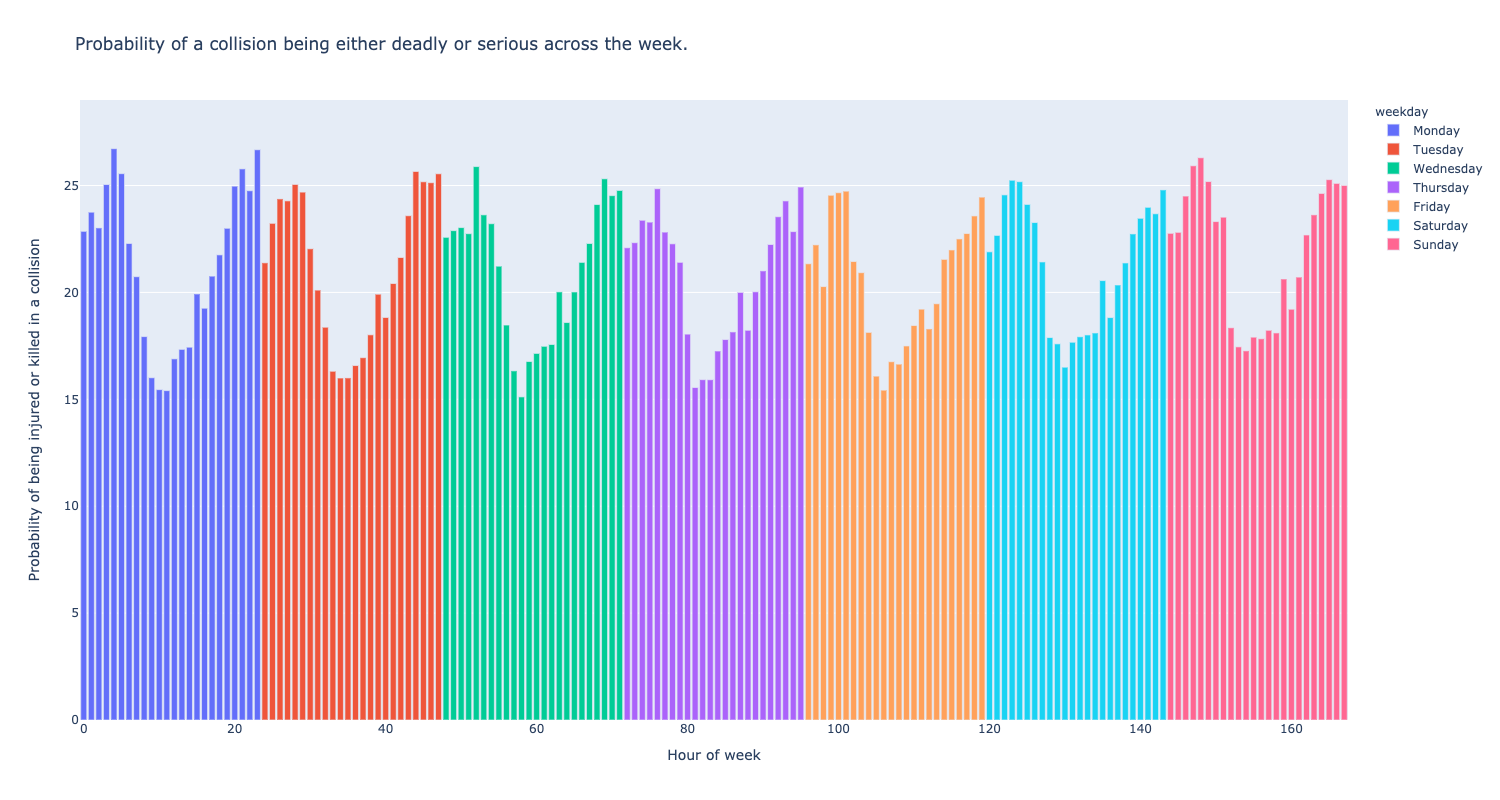

In [2]:
df_plot1 = pd.DataFrame({'hour_of_week'          : np.arange(0,24*7),
                         'only_injured'  : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 0)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'only_killed'   : df.loc[(df['AnyInjured'] == 0)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'both'          : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'either'        : df.loc[(df['AnyInjured'] == 1)|(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'total_count'   : df.groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().values.reshape(-1,order='F'),
                         'weekday'       : np.repeat(list(calendar.day_name),24)})

df_plot1['probability'] = (df_plot1['either']/df_plot1['total_count'])*100
df_plot1['weekday_and_time'] = df_plot1['weekday'] + ' ' + [str(x).zfill(2)+':00' for x in np.arange(0,24)]*7

fig = px.bar(df_plot1,x='hour_of_week', y='probability',
             custom_data=['only_injured', 'only_killed', 'both', 'total_count', 'weekday_and_time'],
             labels = {'hour_of_week' : 'Hour of week', 'probability' : 'Probability of being injured or killed in a collision'},
             color='weekday',
             title='Probability of a collision being either deadly or serious across the week.',
             height=800, width=1500)


fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[4]}</b>",
        "",
        "Number of collisions with only injured: %{customdata[0]}",
        "Number of collisions with only killed: %{customdata[1]}",
        "Number of collisions with both killed and injured: %{customdata[2]}",
        "Total number of collisions: %{customdata[3]}",
        "",
        "Probability of a collision being serious: %{y}%",
    ])
)

fig.update_layout(yaxis_range=[0,np.ceil(df_plot1['probability'].max())+2])
fig.show()

In [4]:
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson') as response:
    counties = json.load(response)
    
zip_and_borough = []
for feature in counties['features']:
    zip_and_borough.append([feature['properties']['borough'], feature['properties']['postalCode']])
    
zip_and_borough = pd.DataFrame(zip_and_borough, columns=['Borough', 'ZIP CODE'])
zip_and_borough['ZIP CODE'] = zip_and_borough['ZIP CODE'].astype(int)

df_temp1 = pd.DataFrame(df.loc[(df['ZIP CODE']) != 0].groupby('ZIP CODE').size().reset_index()); df_temp1.columns = ['ZIP CODE', 'TOTAL COUNT']
df_temp2 = pd.DataFrame(df.loc[(df['ZIP CODE']) != 0].loc[(df['AnyInjured']|df['AnyKilled']).astype(bool)].groupby('ZIP CODE').size().reset_index()); df_temp2.columns = ['ZIP CODE', 'SERIOUS COUNT']

df_temp1['ZIP CODE'] = df_temp1['ZIP CODE'].astype(int)
df_temp2['ZIP CODE'] = df_temp2['ZIP CODE'].astype(int)

df_temp3 = pd.merge(pd.merge(zip_and_borough, df_temp1, how='left', on='ZIP CODE'), df_temp2, how='left', on='ZIP CODE')

df_temp3['SERIOUS COUNT'] = df_temp3['SERIOUS COUNT'].fillna(0).astype(int)
df_temp3['p'] = (df_temp3['SERIOUS COUNT']/df_temp3['TOTAL COUNT'])*100

df_temp3.columns = ['Borough', 'ZIP', 'Total count', 'Serious count', 'p']
df_temp3['p_short'] = np.round(df_temp3['p'],2)
df_temp3 = df_temp3[['ZIP', 'Serious count', 'Total count', 'p', 'p_short', 'Borough']]

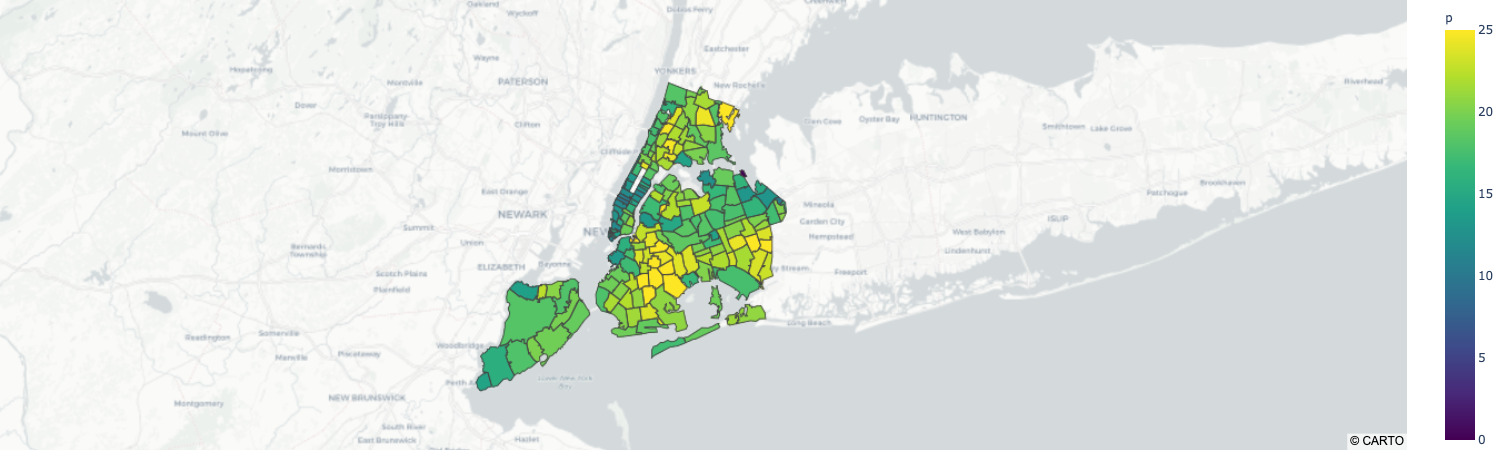

In [5]:
import plotly.express as px

fig = px.choropleth_mapbox(df_temp3, 
                           geojson=counties, locations='ZIP', color='p', featureidkey="properties.postalCode",
                           color_continuous_scale="Viridis",
                           custom_data=['ZIP', 'p_short', 'Serious count', 'Total count', 'Borough'],
                           range_color=(0, 25),
                           center={"lat": 40.730610, "lon": -73.935242},
                           labels={'values':'Number of crashes'},
                           mapbox_style="carto-positron", zoom=9
                          )

fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}, %{customdata[4]}</b>",
        "",
        "Total number of serious collisions: %{customdata[2]}",
        "Total number of collisions: %{customdata[3]}",
        "",
        "Probability of a collision being serious: %{customdata[1]}%",
    ])
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [330]:
unique_factors = np.unique(df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,).astype(str))
contributing_factors = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.astype(str)

In [413]:
data = []
for i, factor in enumerate(unique_factors):
    print(f'#{i+1}/{len(unique_factors)} Evaluating mask for factor {factor}')
    mask = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).apply(lambda x : factor in list(x), axis=1)
    
    serious_count = np.sum(df.loc[mask][['AnyInjured', 'AnyKilled']].sum(axis=1) > 0)
    total_count   = len(df.loc[mask])

    data.append([factor, serious_count, total_count])

data = pd.DataFrame(data, columns=['Factor', 'Serious count', 'Total count'])

#1/62 Evaluating mask for factor 1
#2/62 Evaluating mask for factor 80
#3/62 Evaluating mask for factor Accelerator Defective
#4/62 Evaluating mask for factor Aggressive Driving/Road Rage
#5/62 Evaluating mask for factor Alcohol Involvement
#6/62 Evaluating mask for factor Animals Action
#7/62 Evaluating mask for factor Backing Unsafely
#8/62 Evaluating mask for factor Brakes Defective
#9/62 Evaluating mask for factor Cell Phone (hand-Held)
#10/62 Evaluating mask for factor Cell Phone (hand-held)
#11/62 Evaluating mask for factor Cell Phone (hands-free)
#12/62 Evaluating mask for factor Driver Inattention/Distraction
#13/62 Evaluating mask for factor Driver Inexperience
#14/62 Evaluating mask for factor Driverless/Runaway Vehicle
#15/62 Evaluating mask for factor Drugs (Illegal)
#16/62 Evaluating mask for factor Drugs (illegal)
#17/62 Evaluating mask for factor Eating or Drinking
#18/62 Evaluating mask for factor Failure to Keep Right
#19/62 Evaluating mask for factor Failure to Yield 

In [6]:
data = pd.read_csv('factor_counts.csv')

In [7]:
#Merge Illnes and Illness together.
serious_count, total_count = data.loc[data['Factor'].apply(lambda x : x in ['Illness', 'Illnes'])][['Serious count', 'Total count']].sum(axis=0)

data = data.loc[data['Factor'].apply(lambda x : x not in ['Illness', 'Illnes'])]\
           .append(pd.DataFrame({'Factor' : 'Illness', 'Serious count' : serious_count, 'Total count' : total_count}, index=[0]))

#Merge Drugs (illegal) and Drugs (Illegal) together.
serious_count, total_count = data.loc[data['Factor'].apply(lambda x : x in ['Drugs (illegal)', 'Drugs (Illegal)'])][['Serious count', 'Total count']].sum(axis=0)

data = data.loc[data['Factor'].apply(lambda x : x not in ['Drugs (illegal)', 'Drugs (Illegal)'])]\
           .append(pd.DataFrame({'Factor' : 'Drugs (illegal)', 'Serious count' : serious_count, 'Total count' : total_count}, index=[0]))

#Merge cell phone usage
serious_count, total_count = data.loc[data['Factor'].apply(lambda x : x in ['Cell Phone (hand-Held)', 'Cell Phone (hand-held)'])][['Serious count', 'Total count']].sum(axis=0)

data = data.loc[data['Factor'].apply(lambda x : x not in ['Cell Phone (hand-Held)', 'Cell Phone (hand-held)'])]\
           .append(pd.DataFrame({'Factor' : 'Cell Phone (hand-held)', 'Serious count' : serious_count, 'Total count' : total_count}, index=[0]))



#Drop nonsense factors
data = data.loc[data['Factor'].apply(lambda x : x not in ['1', '80', 'nan', 'Unspecified'])]
data['p'] = (data['Serious count']/data['Total count'])*100
data = data.loc[~pd.isna(data['Factor'])]
data = data.reset_index(drop=True)

In [8]:
pd.DataFrame({'Total count' : np.arange(0, data['Total count'].max()),
              'Expected serious' : np.arange(0, data['Total count'].max())*np.sum(df[['AnyKilled', 'AnyInjured']].sum(axis=1) > 0)/len(df)})

Total count  Expected serious
0                 0          0.000000
1                 1          0.200386
2                 2          0.400772
3                 3          0.601158
4                 4          0.801543
...             ...               ...
342721       342721      68676.436826
342722       342722      68676.637212
342723       342723      68676.837598
342724       342724      68677.037983
342725       342725      68677.238369

[342726 rows x 2 columns]

In [9]:
total_count = np.arange(0, data['Total count'].max())
expected    = total_count*np.sum(df[['AnyKilled', 'AnyInjured']].sum(axis=1) > 0)/len(df)

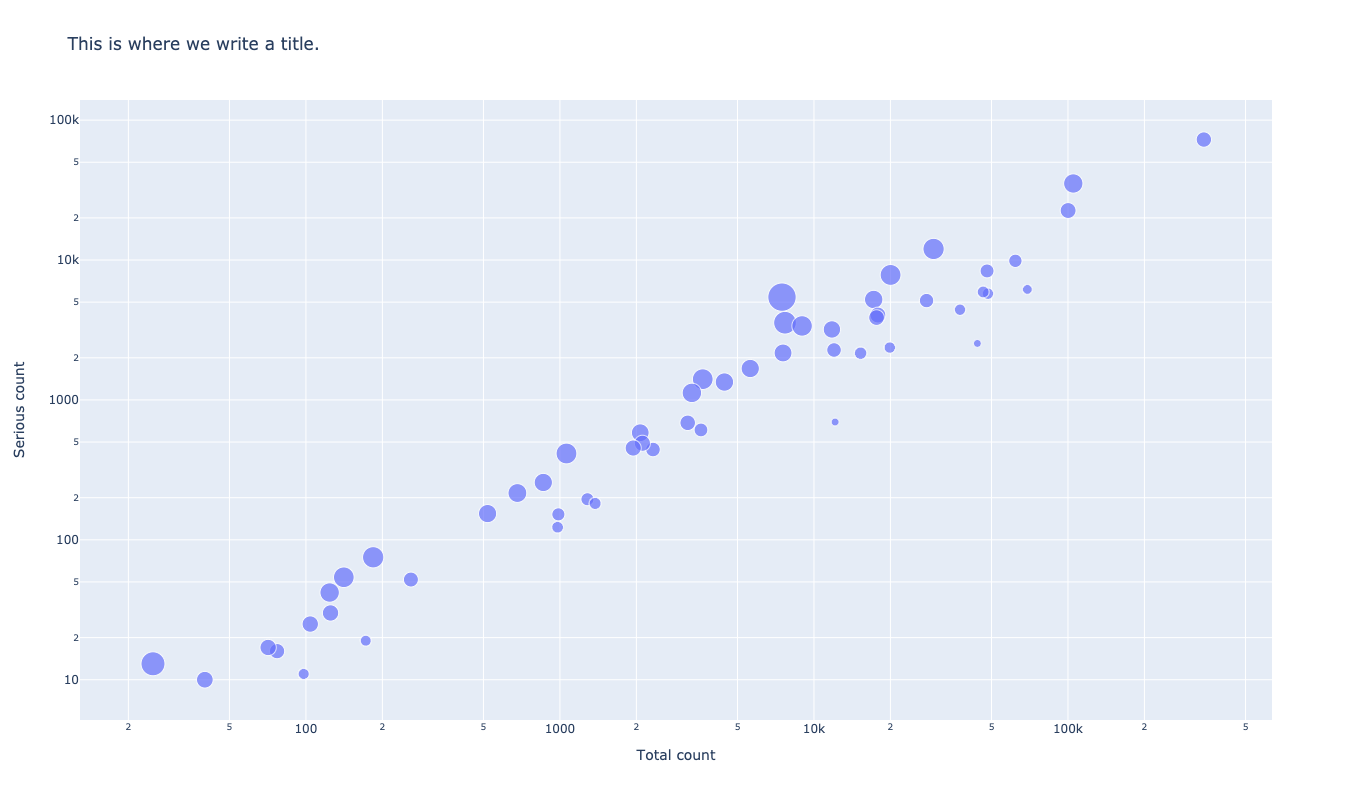

In [11]:
import plotly.graph_objects as go

fig = px.scatter(data, x = 'Total count', y = 'Serious count', size = 'p', hover_data = ['Factor'], log_x=True, log_y=True,
           title='This is where we write a title.',
           width=800, height=800)

fig.show()

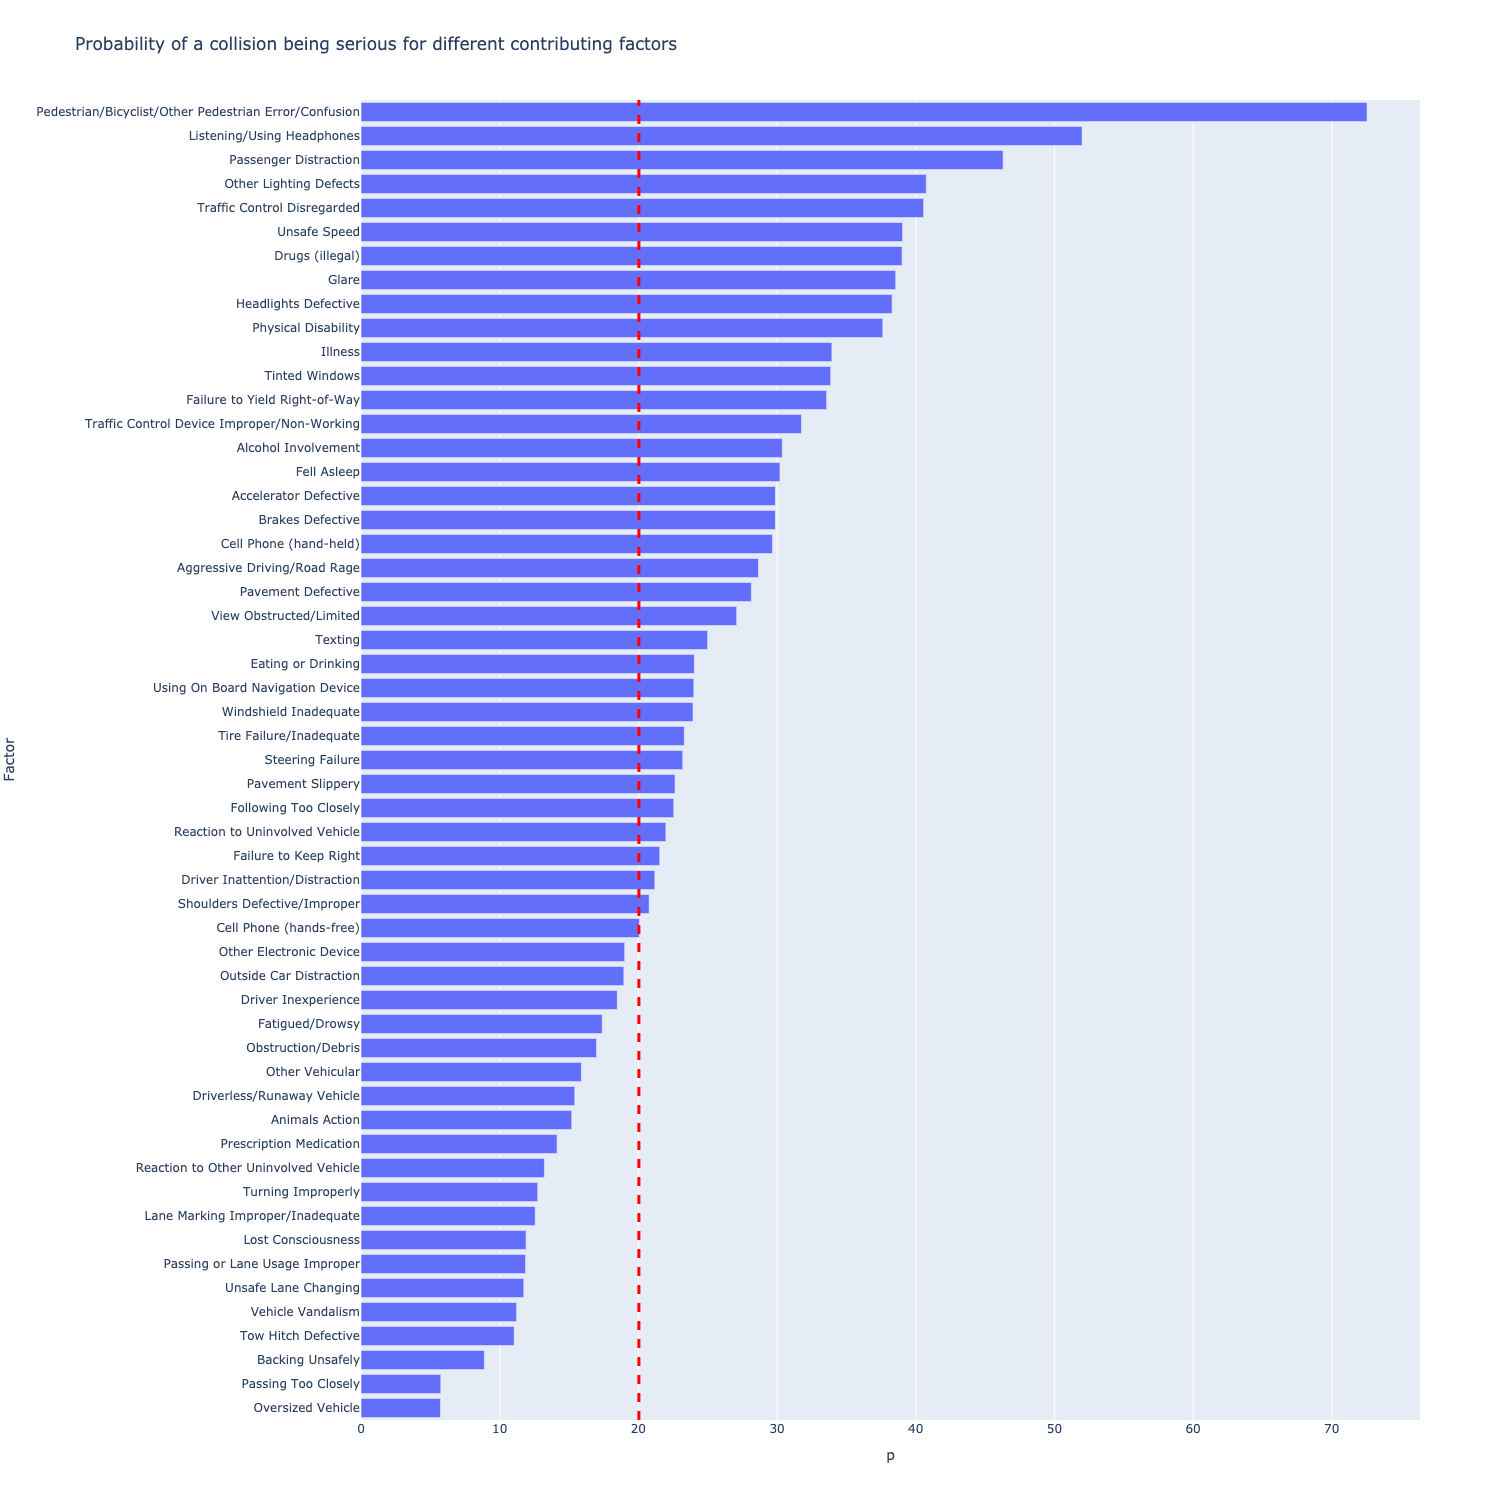

In [12]:
fig = px.bar(data.sort_values('p', ascending=True), x='p', y='Factor', orientation='h',
       width=900, height=1500, title='Probability of a collision being serious for different contributing factors')

fig.add_vline(x=np.sum(df[['AnyInjured', 'AnyKilled']].sum(axis=1) > 0)/len(df)*100, line_width=3, line_dash="dash", line_color="red")
fig.show()

# Looking Into The Most Dangerous Contributing Factor

In [19]:
deadliest_factor = data.loc[data.p == data['p'].max()]['Factor'].item()
deadliest_factor

'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion'

In [21]:
df_subset = df.loc[df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).apply(lambda x : deadliest_factor in list(x), axis=1)]

array(['Aggressive Driving/Road Rage', 'Alcohol Involvement',
       'Backing Unsafely', 'Brakes Defective', 'Cell Phone (hand-Held)',
       'Driver Inattention/Distraction', 'Driver Inexperience',
       'Failure to Keep Right', 'Failure to Yield Right-of-Way',
       'Fatigued/Drowsy', 'Fell Asleep', 'Following Too Closely', 'Glare',
       'Headlights Defective', 'Listening/Using Headphones',
       'Lost Consciousness', 'Obstruction/Debris',
       'Other Electronic Device', 'Other Lighting Defects',
       'Other Vehicular', 'Outside Car Distraction', 'Oversized Vehicle',
       'Passenger Distraction', 'Passing Too Closely',
       'Passing or Lane Usage Improper', 'Pavement Defective',
       'Pavement Slippery',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Physical Disability', 'Prescription Medication',
       'Reaction to Uninvolved Vehicle',
       'Traffic Control Device Improper/Non-Working',
       'Traffic Control Disregarded', 'Turning Improp

In [65]:
dummies = pd.get_dummies(df_subset[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]])

In [66]:
contributing_factors_subset = np.unique(df_subset[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).values.reshape(-1,))

In [67]:
dummy_columns = []

for vehicle in [f'CONTRIBUTING FACTOR VEHICLE {i}_' for i in range(1,6)]:
    for factor in contributing_factors_subset:
        dummy_columns.append(vehicle+factor)
        
for dummy_column in dummy_columns:
    if dummy_column not in dummies.columns:
        dummies[dummy_column] = np.zeros(len(dummies))

In [146]:
data_new = {}
for factor in contributing_factors_subset:
    data_new[factor] = np.any(dummies[[f'CONTRIBUTING FACTOR VEHICLE {i}_{factor}' for i in range(1,6)]], axis=1).astype(int)
    
data_new = pd.DataFrame(data_new)s
data_new = pd.DataFrame(data_new.sum(axis=0)).reset_index()
data_new.columns = ['Factor', 'Count']

data_new = data_new.loc[data_new['Factor'].apply(lambda x : x not in ['nan'])]

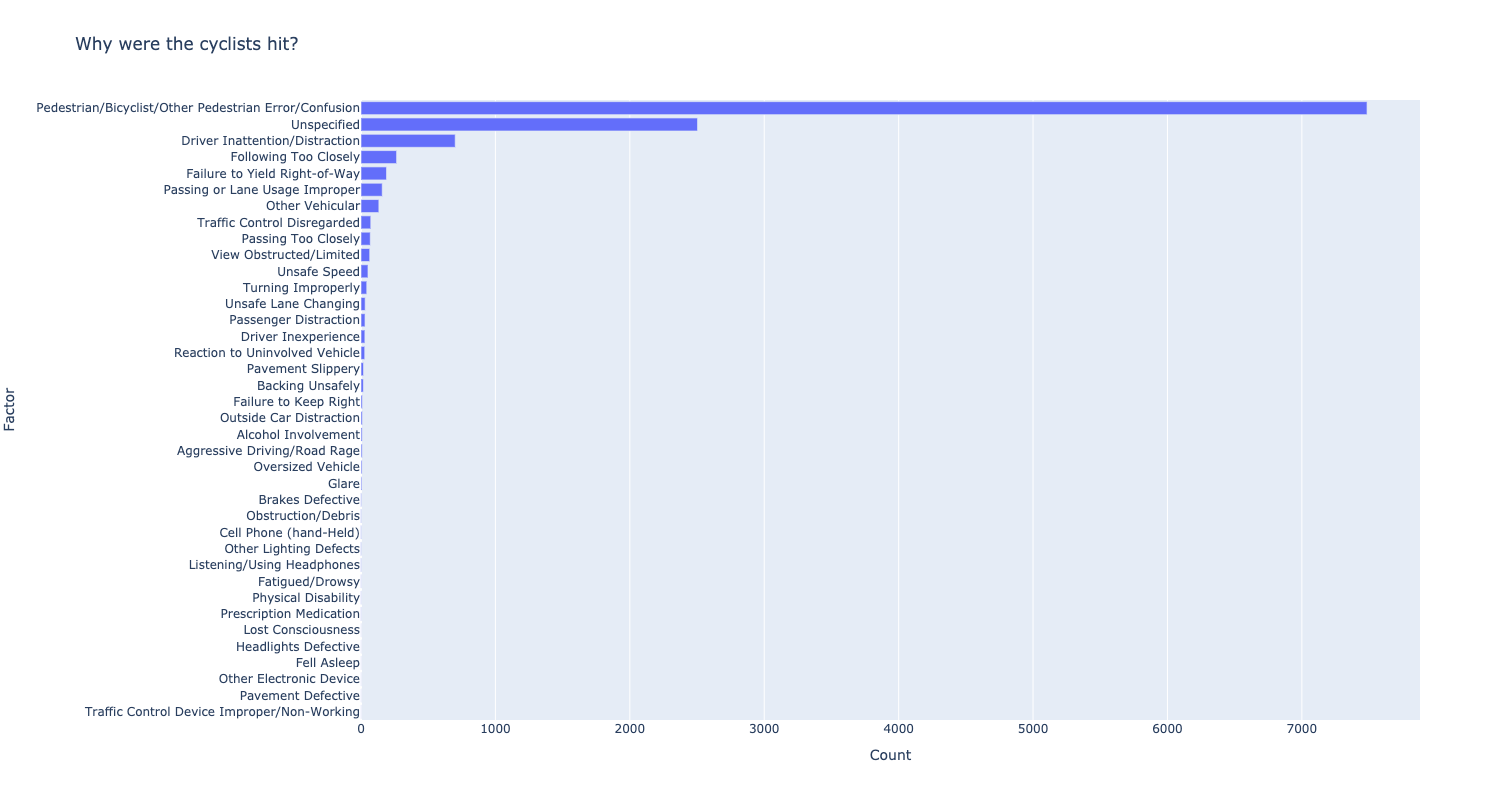

In [147]:
px.bar(data_new.sort_values('Count',ascending=True), x = 'Count', y = 'Factor', orientation='h',
       height=800, title='Why were the cyclists hit?')

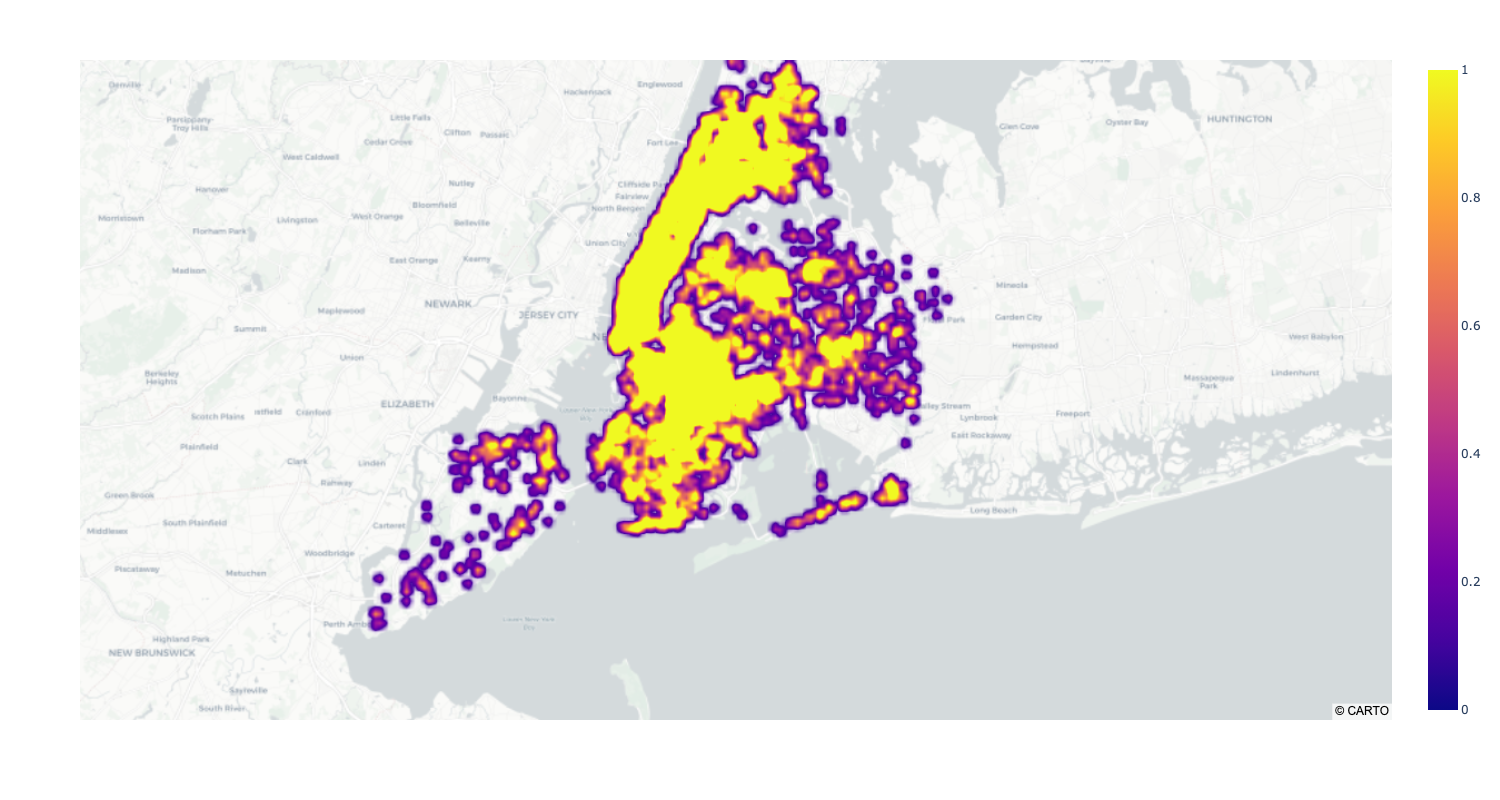

In [207]:
import plotly.express as px
fig = px.density_mapbox(df_subset, lat='LATITUDE', lon='LONGITUDE', radius=8, 
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="carto-positron",
                        width = 800, height = 800)
fig.show()